# Howso Enterprise Data Synthesis Workflow

This notebook will provide a high level overview of the synthetic data generation process, including the final data evaluation for accuracy vs. privacy trade off. More details on each data generation step will be covered in subsequent notebooks.

The process can be broken down into six key steps as illustrated in the diagram below.

<img src="static/synthesizer_process_workflow.png" width="1080">

> ⚠ — `Howso Enterprise` and this recipe require `pyspark` to be installed. In order to conform to as many environments
> as possible, it is not installed automatically.
>
> To install it, run `python -m pip install pyspark<4.0`
> in your Python environment.

## Step 1: Load Data

In [1]:
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from howso.enterprise import Howso, infer_feature_attributes

In [2]:
col_type_mapping = {
    'nih_age': 'Int64', 'nih_alcohol_frequency': 'Int64', 'nih_sex': 'Int64',
    'nih_asthma': 'Int64', 'nih_alc_sub_abuse': 'Int64', 'nih_autoimm': 'Int64',
    'nih_cancer_past_yr': 'Int64', 'nih_chronic_kidney_disease': 'Int64',
    'nih_chronic_lung': 'Int64', 'nih_copd': 'Int64', 'nih_cardiovascular_disease': 'Int64',
    'nih_depression': 'Int64', 'nih_diabetes': 'Int64', 'nih_hypertension': 'Int64',
    'nih_immunocompromised': 'Int64', 'nih_iv_drug_use': 'Int64',
    'nih_other_chronic_cond': 'Int64', 'nih_mental_health_disorder': 'Int64',
    'nih_sickle_cell_disease': 'Int64', 'cov_pan_chal_hlth_2': 'Int64',
    'cov_pan_chal_med_2': 'Int64', 'cov_pan_chlng_trans_2': 'Int64',
    'cov_tst_mthd_2': 'Int64', 'nih_abdom_pain': 'Int64', 'nih_cough': 'Int64',
    'nih_diff_breath': 'Int64', 'nih_fatigue': 'Int64', 'nih_fever_chills': 'Int64',
    'nih_headache': 'Int64', 'nih_muscle_ache': 'Int64',
    'nih_nausea_vomiting_diarrhea': 'Int64', 'nih_olfactory': 'Int64',
    'nih_other_symp': 'Int64', 'covid_pandemic_challenges_abod_2': 'Int64',
    'covid_pandemic_challenges_food_2': 'Int64', 'covid_pandemic_challenges_wate_2': 'Int64',
    'nih_throat_congestion_nose': 'Int64', 'nih_skin_rash': 'Int64',
    'covid_test_approval': 'Int64', 'covid_test_collection_setting': 'Int64',
    'covid_test_performed_location': 'Int64', 'covid_test_result': 'Int64',
    'covid_test_specimen_collector': 'Int64', 'covid_test_specimen_type': 'Int64',
    'covid_test_study_setting': 'Int64', 'covid_test_tar_dis_stat_2___1': 'Int64',
    'covid_test_tar_dis_stat_2___2': 'Int64', 'covid_test_tar_dis_stat_2___3': 'Int64',
    'covid_test_tar_dis_stat_2___4': 'Int64', 'covid_test_tar_dis_stat_2___5': 'Int64',
    'covid_test_tar_dis_stat_2___6': 'Int64', 'covid_test_tar_dis_stat_2___9': 'Int64',
    'covid_test_type': 'Int64', 'covid_vaccine': 'Int64', 'nih_employment': 'Int64',
    'nih_education': 'Int64', 'employed_ew': 'Int64', 'employed_healthcare_2': 'Int64',
    'family_income': 'Int64', 'flu_vaccine_season_3': 'Int64',
    'flu_vaccinehistind_2': 'Int64', 'gender_identity_term_2': 'Int64',
    'nih_insurance': 'Int64', 'hi_loss_covid': 'Int64', 'household_congregate_3': 'Int64',
    'household_famgen_3': 'Int64', 'household_homeless': 'Int64',
    'isolate_maintain_job': 'Int64', 'jobloss_covid19_2': 'Int64', 'language_english': 'Int64',
    'language_home___1': 'Int64', 'language_home___2': 'Int64', 'language_home___3': 'Int64',
    'language_home___4': 'Int64', 'language_home___5': 'Int64', 'language_home___6': 'Int64',
    'language_home___7': 'Int64', 'language_home___8': 'Int64', 'language_home___9': 'Int64',
    'language_home___90': 'Int64', 'language_home___99': 'Int64',
    'nih_lifetime_use_alcohol': 'Int64', 'positivemonth_covidtest_2': 'Int64',
    'positiveyear_covidtest_3': 'Int64', 'nih_pregnancy': 'Int64',
    'quarantine_maintain_job': 'Int64', 'race_ethn_asian_detail_3___1': 'Int64',
    'race_ethn_asian_detail_3___2': 'Int64', 'race_ethn_asian_detail_3___3': 'Int64',
    'race_ethn_asian_detail_3___4': 'Int64', 'race_ethn_asian_detail_3___5': 'Int64',
    'race_ethn_asian_detail_3___99': 'Int64', 'nih_ethnicity': 'Int64',
    'race_ethn_hispanic_detail_2___1': 'Int64', 'race_ethn_hispanic_detail_2___2': 'Int64',
    'race_ethn_hispanic_detail_2___3': 'Int64', 'race_ethn_hispanic_detail_2___4': 'Int64',
    'race_ethn_hispanic_detail_2___5': 'Int64', 'race_ethn_hispanic_detail_2___6': 'Int64',
    'race_ethn_hispanic_detail_2___7': 'Int64', 'race_ethn_hispanic_detail_2___99': 'Int64',
    'race_ethn_islander_detail_2___1': 'Int64', 'race_ethn_islander_detail_2___10': 'Int64',
    'race_ethn_islander_detail_2___11': 'Int64', 'race_ethn_islander_detail_2___12': 'Int64',
    'race_ethn_islander_detail_2___13': 'Int64', 'race_ethn_islander_detail_2___14': 'Int64',
    'race_ethn_islander_detail_2___2': 'Int64', 'race_ethn_islander_detail_2___3': 'Int64',
    'race_ethn_islander_detail_2___4': 'Int64', 'race_ethn_islander_detail_2___5': 'Int64',
    'race_ethn_islander_detail_2___6': 'Int64', 'race_ethn_islander_detail_2___7': 'Int64',
    'race_ethn_islander_detail_2___8': 'Int64', 'race_ethn_islander_detail_2___9': 'Int64',
    'race_ethn_islander_detail_2___99': 'Int64', 'recentmonth_covidtest_2': 'Int64',
    'recentresult_covidtest': 'Int64', 'recentyear_covidtest_3': 'Int64',
    'nih_disability': 'Int64', 'nih_health_status': 'Int64',
    'self_reported_weight_units_2': 'Int64', 'sex_orient_id': 'Int64',
    'nih_history_smoking': 'Int64', 'smoker_number': 'float64', 'test_accesseasy_2': 'Int64',
    'test_accesswhere_2': 'Int64', 'tested_for_covid': 'Int64',
    'tested_positive_for_covid': 'Int64', 'vaccine_avail': 'Int64',
    'vaccine_concerns_3___1': 'Int64', 'vaccine_concerns_3___10': 'Int64',
    'vaccine_concerns_3___2': 'Int64', 'vaccine_concerns_3___3': 'Int64',
    'vaccine_concerns_3___4': 'Int64', 'vaccine_concerns_3___5': 'Int64',
    'vaccine_concerns_3___6': 'Int64', 'vaccine_concerns_3___7': 'Int64',
    'vaccine_concerns_3___8': 'Int64', 'vaccine_concerns_3___9': 'Int64',
    'vaccine_concerns_3___96': 'Int64', 'vaccine_reasons_3___1': 'Int64',
    'vaccine_reasons_3___10': 'Int64', 'vaccine_reasons_3___11': 'Int64',
    'vaccine_reasons_3___2': 'Int64', 'vaccine_reasons_3___3': 'Int64',
    'vaccine_reasons_3___4': 'Int64', 'vaccine_reasons_3___5': 'Int64',
    'vaccine_reasons_3___6': 'Int64', 'vaccine_reasons_3___7': 'Int64',
    'vaccine_reasons_3___8': 'Int64', 'vaccine_reasons_3___9': 'Int64',
    'vaccine_reasons_3___96': 'Int64', 'nih_vape_freq': 'Int64', 'work_closecont_2': 'Int64',
    'work_ppe_2': 'Int64', 'work_wash_2': 'Int64', 'nih_zip': 'string', 'nih_weight': 'Int64',
    'nih_height': 'Int64', 'nih_race': 'Int64', 'nih_alcohol_yn': 'Int64',
    'nih_cig_smoke_freq': 'Int64', 'nih_smoking_yn': 'Int64'}
print(f'total number of columns being mapped: {len(col_type_mapping)}')

data_path = Path("/home", "sagemaker-user", "phs002660", "project14_DATA_transformcopy_v3_processed.csv")
df = pd.read_csv(data_path, dtype=col_type_mapping)
df = df.reset_index(drop=True)
print(df.columns)
print(f'total number of rows: {len(df)}')

# for model comparison for covid_test_result prediction, nulls from target feature should be removed and all-null columns should be removed as well
target_feature = 'covid_test_result'
df = df.dropna(subset=[target_feature])
df = df[df[target_feature] != 3]
print(f'after removing null and extraneous rows, df.shape: {df.shape}')
null_only_cols = df.columns[df.isna().all()].tolist()
print(null_only_cols)
df = df.drop(columns=null_only_cols)
df = df.reset_index(drop=True)
print(f'input dataframe shape after processing: {df.shape}')
pd.set_option('display.max_columns', None)
df.describe()

total number of columns being mapped: 164
Index(['nih_age', 'nih_alcohol_frequency', 'nih_sex', 'nih_asthma',
       'nih_alc_sub_abuse', 'nih_autoimm', 'nih_cancer_past_yr',
       'nih_chronic_kidney_disease', 'nih_chronic_lung', 'nih_copd',
       ...
       'work_closecont_2', 'work_ppe_2', 'work_wash_2', 'nih_zip',
       'nih_weight', 'nih_height', 'nih_race', 'nih_alcohol_yn',
       'nih_cig_smoke_freq', 'nih_smoking_yn'],
      dtype='object', length=164)
total number of rows: 5102
after removing null and extraneous rows, df.shape: (4582, 164)
['nih_alcohol_frequency', 'cov_tst_mthd_2', 'covid_pandemic_challenges_wate_2', 'employed_ew', 'family_income', 'nih_insurance', 'hi_loss_covid', 'household_congregate_3', 'nih_lifetime_use_alcohol', 'positivemonth_covidtest_2', 'positiveyear_covidtest_3', 'recentmonth_covidtest_2', 'recentresult_covidtest', 'recentyear_covidtest_3', 'nih_disability', 'nih_health_status', 'nih_history_smoking', 'smoker_number', 'test_accesseasy_2', 'test

,nih_age,nih_sex,nih_asthma,nih_alc_sub_abuse,nih_autoimm,nih_cancer_past_yr,nih_chronic_kidney_disease,nih_chronic_lung,nih_copd,nih_cardiovascular_disease,nih_depression,nih_diabetes,nih_hypertension,nih_immunocompromised,nih_iv_drug_use,nih_other_chronic_cond,nih_mental_health_disorder,nih_sickle_cell_disease,cov_pan_chal_hlth_2,cov_pan_chal_med_2,cov_pan_chlng_trans_2,nih_abdom_pain,nih_cough,nih_diff_breath,nih_fatigue,nih_fever_chills,nih_headache,nih_muscle_ache,nih_nausea_vomiting_diarrhea,nih_olfactory,nih_other_symp,covid_pandemic_challenges_abod_2,covid_pandemic_challenges_food_2,nih_throat_congestion_nose,nih_skin_rash,covid_test_approval,covid_test_collection_setting,covid_test_performed_location,covid_test_result,covid_test_specimen_collector,covid_test_specimen_type,covid_test_study_setting,covid_test_tar_dis_stat_2___1,covid_test_tar_dis_stat_2___2,covid_test_tar_dis_stat_2___3,covid_test_tar_dis_stat_2___4,covid_test_tar_dis_stat_2___5,covid_test_tar_dis_stat_2___6,covid_test_tar_dis_stat_2___9,covid_test_type,covid_vaccine,nih_employment,nih_education,employed_healthcare_2,flu_vaccine_season_3,flu_vaccinehistind_2,gender_identity_term_2,household_famgen_3,household_homeless,isolate_maintain_job,jobloss_covid19_2,language_english,language_home___1,language_home___2,language_home___3,language_home___4,language_home___5,language_home___6,language_home___7,language_home___8,language_home___9,language_home___90,language_home___99,nih_pregnancy,quarantine_maintain_job,race_ethn_asian_detail_3___1,race_ethn_asian_detail_3___2,race_ethn_asian_detail_3___3,race_ethn_asian_detail_3___4,race_ethn_asian_detail_3___5,race_ethn_asian_detail_3___99,nih_ethnicity,race_ethn_hispanic_detail_2___1,race_ethn_hispanic_detail_2___2,race_ethn_hispanic_detail_2___3,race_ethn_hispanic_detail_2___4,race_ethn_hispanic_detail_2___5,race_ethn_hispanic_detail_2___6,race_ethn_hispanic_detail_2___7,race_ethn_hispanic_detail_2___99,race_ethn_islander_detail_2___1,race_ethn_islander_detail_2___10,race_ethn_islander_detail_2___11,race_ethn_islander_detail_2___12,race_ethn_islander_detail_2___13,race_ethn_islander_detail_2___14,race_ethn_islander_detail_2___2,race_ethn_islander_detail_2___3,race_ethn_islander_detail_2___4,race_ethn_islander_detail_2___5,race_ethn_islander_detail_2___6,race_ethn_islander_detail_2___7,race_ethn_islander_detail_2___8,race_ethn_islander_detail_2___9,race_ethn_islander_detail_2___99,self_reported_weight_units_2,sex_orient_id,vaccine_avail,vaccine_concerns_3___1,vaccine_concerns_3___10,vaccine_concerns_3___2,vaccine_concerns_3___3,vaccine_concerns_3___4,vaccine_concerns_3___5,vaccine_concerns_3___6,vaccine_concerns_3___7,vaccine_concerns_3___8,vaccine_concerns_3___9,vaccine_concerns_3___96,vaccine_reasons_3___1,vaccine_reasons_3___10,vaccine_reasons_3___11,vaccine_reasons_3___2,vaccine_reasons_3___3,vaccine_reasons_3___4,vaccine_reasons_3___5,vaccine_reasons_3___6,vaccine_reasons_3___7,vaccine_reasons_3___8,vaccine_reasons_3___9,vaccine_reasons_3___96,nih_weight,nih_height,nih_race
count,4581.0,4518.0,71.0,71.0,71.0,71.0,71.0,1294.0,71.0,1294.0,71.0,1294.0,324.0,71.0,71.0,1294.0,71.0,71.0,79.0,79.0,79.0,649.0,1874.0,1873.0,1873.0,1875.0,652.0,1873.0,649.0,1873.0,1872.0,79.0,79.0,1875.0,649.0,3969.0,4011.0,4011.0,4582.0,4013.0,4011.0,4008.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,3969.0,214.0,147.0,227.0,42.0,27.0,117.0,142.0,168.0,3.0,155.0,117.0,2740.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,1482.0,4582.0,1482.0,556.0,102.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4581.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,429.0,282.0,78.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,146.0,66.0,4581.0
mean,33.244925,0.585657,0.028169,0.0,0.0,0.0,0.0,0.001546,0.0,0.00541,

## Step 2: Map Data

Confirm the data types are detected correctly.


In [4]:
continuous_feats = ['nih_age', 'nih_weight', 'nih_height']

features = infer_feature_attributes(df, attempt_infer_extended_nominals=True, infer_bounds=True,
                                    tight_bounds=continuous_feats + [target_feature],
                                    types={"continuous": continuous_feats}
                                    )

# As this is just a recipe notebook and not an attempt at creating anonymous data, we are setting the nominal features as `non_sensitive`.
# When creating anonymous data, you should only set nominal features as non_sensitive if they are truly non_sensitive.
# For example, when attempting to create anonymous data, we strongly recommend that nominals are encoded, which can be achieved by the following utility code:
subtype_map = {
    "nih_zip": "int-id"
}

for feature, subtype in subtype_map.items():
    features[feature]["type"] = "nominal"
    features[feature]["subtype"] = subtype

for f_name in features.get_names(types=("continuous")):
    if f_name not in continuous_feats:
        print(f'changing inferred continuous feature: {f_name} to nominal')
        features[f_name]["type"] = "nominal"

features[target_feature]["bounds"] = {'allow_null': False}

features.to_dataframe()
print(features[target_feature])

changing inferred continuous feature: employed_healthcare_2 to nominal
changing inferred continuous feature: household_homeless to nominal
{'type': 'nominal', 'data_type': 'number', 'decimal_places': 0, 'original_type': {'data_type': 'integer', 'size': 8}, 'bounds': {'allow_null': False}, 'subtype': 'int-id'}


## Step 3: Set Desired Parameters

- Desired parameter: Synthesizer allows the user to tune synthetic data based on privacy / accuracy requirements, this notebook will use the default settings which provides a good balance between accuracy and privacy


## Step 4-6: Characterize Data, Generate New Data, Analyze Data

> ⚠ Note: To parameterize synthesis using epsilon (differential privacy), use the `epsilon_upper_bound` parameter to `Howso.synthesize()`
> instead of `desired_conviction`. Validator's `AnonymityPreservation` measures epsilon post-synthesis by accessing the average distance between each synthetic point and its nearest original record, which may be used to validate that the empirical epsilon is below `epsilon_upper_bound`.

- Characterize Data: Synthesizer preserves the distribution in the original dataset by default and cross-shreds the original data so there will not be a 1-to-1 mapping to the original dataset to maintain privacy. 

- Analyze Data: Validator uses the same Trainee as Synthesizer to analyze the quality _and_ privacy of the synthesis.

- Characterizing, generating, and analyzing new synthetic data with Synthesizer & Validator using the parameters described above is as simple as:


In [5]:
tests_to_run = [
    "AnonymityPreservation",
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",
    # FeatureImportanceComparison is expensive and you should consider disabling it for large datasets,
    # particularly datasets with many features.
    "FeatureImportanceComparison",
]

# Instantiate our compute environment. In this case it is Howso Standalone running on a local machine.
with Howso() as howso:
    results = howso.synthesize(
        # Perform the synthesis, with validation
        source_data=df,
        features=features,
        use_id_privacy=False,
        privacy_override=True,
        validate_options={"metrics": tests_to_run},
    )

display(results.destination_data.get_dataframe())


Version 50.2.2 of Howso Engine™ is available. You are using version 50.2.1.


Train chunk «synthesized_data:chunk-1» with 4,582 samples took 0:00:00.940941.
Analyze chunk «synthesized_data:chunk-1» with 4,582 samples took 0:01:35.690639.
Synthesize chunk «synthesized_data:chunk-1» with 4,582 samples took 0:07:15.349852.


/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/nominal_substitution/substitution_engine.py:205: UserWarning: Neither the system locale (C) or the configured locale(s) [] are available in Faker. (https://faker.readthedocs.io/en/master/locales.html) Locale for Faker will be set to en_US.
  warnings.warn(


Validate chunk «synthesized_data:chunk-1» with 4,582 samples took 0:10:23.764960.
Validator desirability results of chunk «synthesized_data:chunk-1»: AnonymityPreservation: 5.0 | DescriptiveStatistics: 2.145 | JointProbability: 3.577 | ModelComparison: 3.451 | FeatureImportanceComparison: 3.565
Processing complete.
Synthesizing DataFrameData8773443465629 to /home/sagemaker-user/synthesized_data.csv via chunks of 25,000 samples with 1 workers required 0:19:21.375958.
Wall clock: 0:19:21.375958, Train: 0:00:00.940941 (0.1%), 
Analyze: 0:01:35.690639 (8.3%), 
Synthesis: 0:07:15.349852 (37.7%), 
Validation: 0:10:23.764960 (54.0%), Total CPU: 0:19:15.746392.


,nih_age,nih_sex,nih_asthma,nih_alc_sub_abuse,nih_autoimm,nih_cancer_past_yr,nih_chronic_kidney_disease,nih_chronic_lung,nih_copd,nih_cardiovascular_disease,nih_depression,nih_diabetes,nih_hypertension,nih_immunocompromised,nih_iv_drug_use,nih_other_chronic_cond,nih_mental_health_disorder,nih_sickle_cell_disease,cov_pan_chal_hlth_2,cov_pan_chal_med_2,cov_pan_chlng_trans_2,nih_abdom_pain,nih_cough,nih_diff_breath,nih_fatigue,nih_fever_chills,nih_headache,nih_muscle_ache,nih_nausea_vomiting_diarrhea,nih_olfactory,nih_other_symp,covid_pandemic_challenges_abod_2,covid_pandemic_challenges_food_2,nih_throat_congestion_nose,nih_skin_rash,covid_test_approval,covid_test_collection_setting,covid_test_performed_location,covid_test_result,covid_test_specimen_collector,covid_test_specimen_type,covid_test_study_setting,covid_test_tar_dis_stat_2___1,covid_test_tar_dis_stat_2___2,covid_test_tar_dis_stat_2___3,covid_test_tar_dis_stat_2___4,covid_test_tar_dis_stat_2___5,covid_test_tar_dis_stat_2___6,covid_test_tar_dis_stat_2___9,covid_test_type,covid_vaccine,nih_employment,nih_education,employed_healthcare_2,flu_vaccine_season_3,flu_vaccinehistind_2,gender_identity_term_2,household_famgen_3,household_homeless,isolate_maintain_job,jobloss_covid19_2,language_english,language_home___1,language_home___2,language_home___3,language_home___4,language_home___5,language_home___6,language_home___7,language_home___8,language_home___9,language_home___90,language_home___99,nih_pregnancy,quarantine_maintain_job,race_ethn_asian_detail_3___1,race_ethn_asian_detail_3___2,race_ethn_asian_detail_3___3,race_ethn_asian_detail_3___4,race_ethn_asian_detail_3___5,race_ethn_asian_detail_3___99,nih_ethnicity,race_ethn_hispanic_detail_2___1,race_ethn_hispanic_detail_2___2,race_ethn_hispanic_detail_2___3,race_ethn_hispanic_detail_2___4,race_ethn_hispanic_detail_2___5,race_ethn_hispanic_detail_2___6,race_ethn_hispanic_detail_2___7,race_ethn_hispanic_detail_2___99,race_ethn_islander_detail_2___1,race_ethn_islander_detail_2___10,race_ethn_islander_detail_2___11,race_ethn_islander_detail_2___12,race_ethn_islander_detail_2___13,race_ethn_islander_detail_2___14,race_ethn_islander_detail_2___2,race_ethn_islander_detail_2___3,race_ethn_islander_detail_2___4,race_ethn_islander_detail_2___5,race_ethn_islander_detail_2___6,race_ethn_islander_detail_2___7,race_ethn_islander_detail_2___8,race_ethn_islander_detail_2___9,race_ethn_islander_detail_2___99,self_reported_weight_units_2,sex_orient_id,vaccine_avail,vaccine_concerns_3___1,vaccine_concerns_3___10,vaccine_concerns_3___2,vaccine_concerns_3___3,vaccine_concerns_3___4,vaccine_concerns_3___5,vaccine_concerns_3___6,vaccine_concerns_3___7,vaccine_concerns_3___8,vaccine_concerns_3___9,vaccine_concerns_3___96,vaccine_reasons_3___1,vaccine_reasons_3___10,vaccine_reasons_3___11,vaccine_reasons_3___2,vaccine_reasons_3___3,vaccine_reasons_3___4,vaccine_reasons_3___5,vaccine_reasons_3___6,vaccine_reasons_3___7,vaccine_reasons_3___8,vaccine_reasons_3___9,vaccine_reasons_3___96,nih_zip,nih_weight,nih_height,nih_race
0,28.0,8.352129e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.997875e+18,2.567245e+18,7.958602e+18,1.645791e+18,7.157714e+18,8.157602e+18,8.436856e+18,8.741767e+18,8.320815e+18,6.112704e+18,NaN,NaN,1.063438e+18,1.855273e+18,NaN,NaN,NaN,4274062309447711801,NaN,NaN,NaN,362663513493443398,5168404374250652913,371643805582366640,1052813142420474282,9071613516606930490,1382784731720919436,1658659815149454259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.978322e+18,7264740068746239040,8716741808888819387,5145522437365562711,270721939354805898,7963372920463207750,1864471463646971589,8208570136640355433,3910961599211203563,NaN,4872218518592171955,NaN,NaN,NaN,8859637345315484054,1139534050761751891,1038221577579690181,1525061895791014175,2561253622916143224,1905803277324951078,5.053251e+18,3509510255110474303,8327816772391715562,7517224368984132942,1231621825402435169,5634174996539482080,79469284013370

### Step 6.1: Inspect results

For the data set we will do a simple visual comparison and calculate the descriptive statistics along with classification accuracy between the original vs. the synthesized data to determine the quality of synthesis

nih_age Int64 0 90
nih_weight Int64 29 280
nih_height Int64 50 71


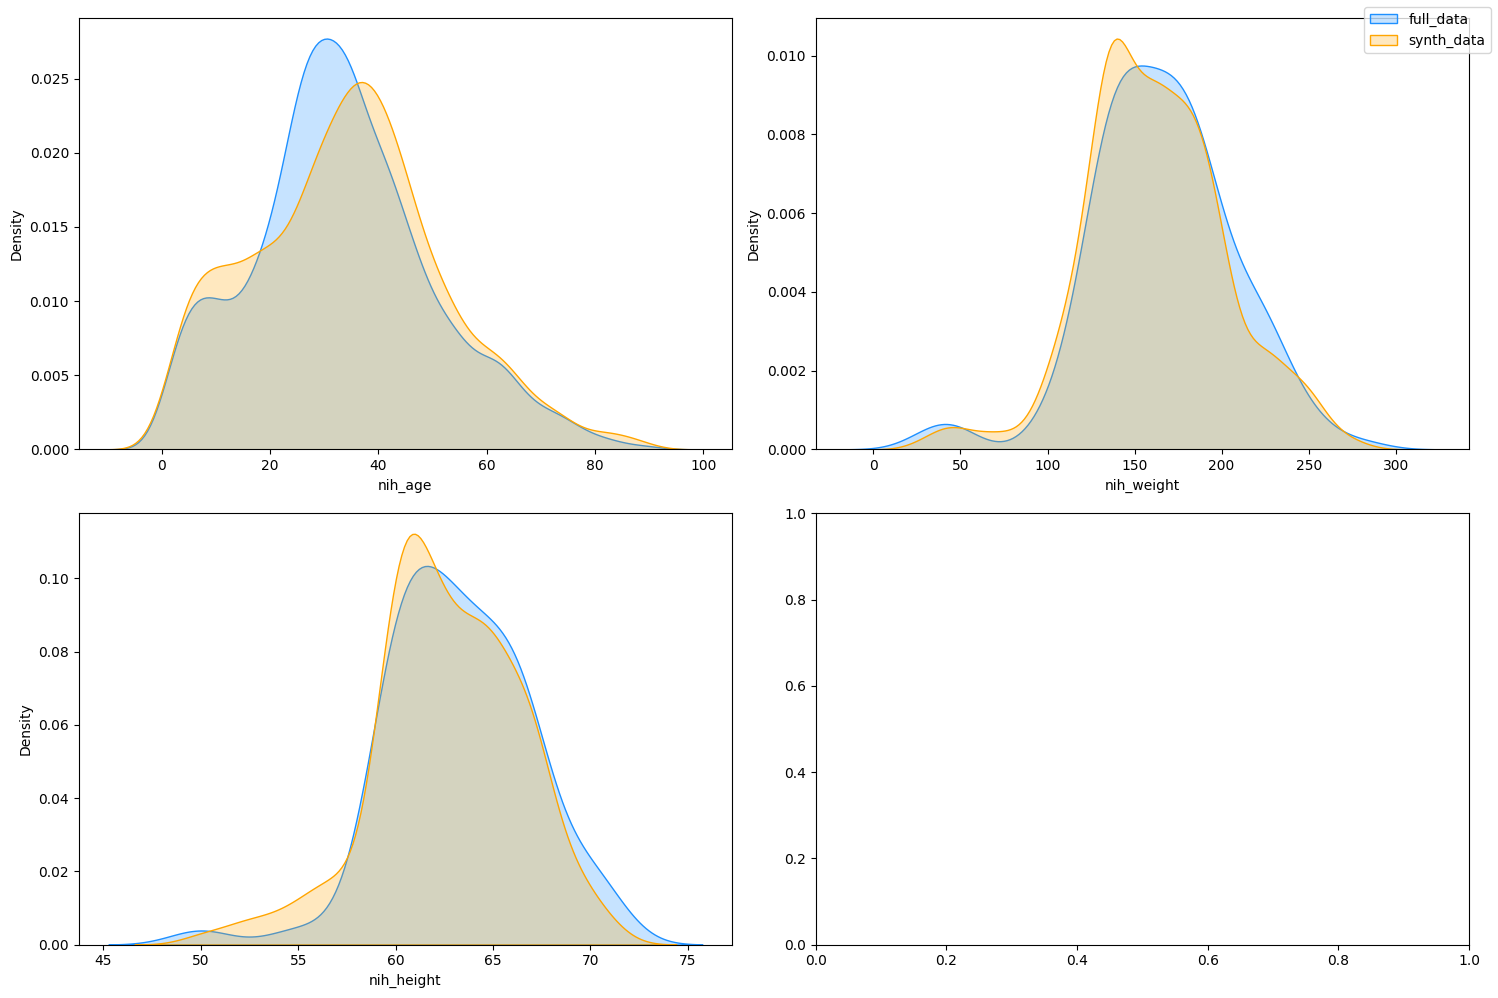

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]

for c, ax in zip(df.columns.drop(categorical_features), axes.flat):    
    print(c, df[c].dtypes, df[c].min(), df[c].max())
    if df[c].dtypes != 'string':
        sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
        sns.kdeplot(ax=ax, x=results.destination_data.get_dataframe()[c], color="orange", label="full_data", fill=True)
        ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [7]:
for name, result in sorted(results.validate_results.items()):
    display(Markdown(f"### {name} - Desirability: {result.desirability}"))
    display(Markdown(result.description))
    display(result.get_df())

### AnonymityPreservation - Desirability: 5.0

Measure how well the generated data preserve the privacy of the original data by comparing the distance from each generated case to its nearest original neighbor. This distance is divided by the smallest or average distance in that original neighbor's region, acting as a proxy for density called the distance ratio. If this ratio is at least 1, then privacy is maintained. If this ratio is at least 0.5, then plausible deniability is maintained. Desirability is computed on the worst case by default, with a desirability of 5 corresponding to a minimum distance ratio of 1 or greater. Also of note is the measured epsilon portion of the results. In differential privacy, this indicates the amount of the privacy budget that was actually consumed during synthesis. The total privacy budget is indicated by the `epsilon_upper_bound` parameter to `Synthesizer.synthesize_cases`, if specified.

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1.0,"(0.049787068367863944, 5, 20)",1.0,min,398.513876,12.509884,1.008306,5.0


### DescriptiveStatistics - Desirability: 2.145

Shows differences in `basic statistics` between the features of the original and generated data.

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1.0,original,language_home___9,mode,1.0,NaN
1,1.0,generated,language_home___9,mode,2858670582937810432.0,NaN
2,1.0,original,language_home___9,entropy,0.0,5.000000
3,1.0,generated,language_home___9,entropy,0.0,5.000000
4,1.0,original,language_home___9,uniques,1.0,5.000000
...,...,...,...,...,...,...
847,1.0,generated,vaccine_concerns_3___9,mode,180681255069535232.0,NaN
848,1.0,original,vaccine_concerns_3___9,entropy,0.003813,0.030152
849,1.0,generated,vaccine_concerns_3___9,entropy,0.280599,0.030152
850,1.0,original,vaccine_concerns_3___9,uniques,2.0,5.000000


### FeatureImportanceComparison - Desirability: 3.565

Builds and trains Trainees using original and generated data to compute Feature Robust Accuracy Contributions and Feature Robust Prediction Contributions. The feature importance rankings of the original and generated data are then compared using Rank-Biased Overlap (RBO) and Wasserstein Distance, also called Earth-Mover Distance (EMD), statistical methods. The geometric mean of the scaled RBO and EMD statistics is used as the desirability score. A desirability near 5 represents near similar feature importance rankings, desirability in the 4-3 range represents minor shuffling of important features, and a desirability of 2 or less represents the major shuffling of important features. Using the test_data argument can be used to give more accurate estimates by holding out data from both the original and the process used to generate data. However, by holding out test data from the data generation process, the generated data may be less accurate. The actual accuracy loss is expectation between the accuracy loss measured with and without using holdout test_data.

,run_number,action_feature,feature_importance_type,measure,measure_value,desirability
0,1.0,nih_age,ac,rbo,0.895833,4.746
1,1.0,nih_age,pc,rbo,0.312500,2.986
2,1.0,nih_age,ac,wasserstein,0.287766,4.330
3,1.0,nih_age,pc,wasserstein,1.148500,2.113
4,1.0,nih_weight,ac,rbo,0.937500,5.000
5,1.0,nih_weight,pc,rbo,0.812500,4.553
6,1.0,nih_weight,ac,wasserstein,0.837468,5.000
7,1.0,nih_weight,pc,wasserstein,3.942250,0.697
8,1.0,household_homeless,ac,rbo,0.312500,3.546
9,1.0,household_homeless,pc,rbo,0.770833,4.210


### JointProbability - Desirability: 3.577

Measure how well the generated data capture the joint distribution of the original data by estimating the PDF of the data and computing the Jensen-Shannon divergence between both estimates.

,run_number,k,p,js,desirability
0,1.0,"[0.049787068367863944, 5, 20]",1.0,0.284542,3.577


### ModelComparison - Desirability: 3.451

Measure how well the generated data can act as a substitute for the original data by comparing model performance. Specifically, trains one model on a training set of the original data and one model on a training set of the generated data and evaluates them both against a test set of the original data. Desirability goes towards 5 as the performance becomes more similar. Degradations in performance of the generated model (e.g., lower accuracy) are punished more harshly than improvements in performance.

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1.0,original,Howso,nih_age,rmse,16.543423,4.711000
1,1.0,generated,Howso,nih_age,rmse,17.364525,4.711000
2,1.0,original,Howso,nih_age,mae,12.792803,4.686000
3,1.0,generated,Howso,nih_age,mae,13.485278,4.686000
4,1.0,original,Howso,nih_age,spearman,0.505068,4.755000
5,1.0,generated,Howso,nih_age,spearman,0.482526,4.755000
6,1.0,original,Howso,nih_age,r2,-0.011433,4.823609
7,1.0,generated,Howso,nih_age,r2,-0.114326,4.823609
8,1.0,original,Howso,nih_weight,rmse,36.230295,1.874000
9,1.0,generated,Howso,nih_weight,rmse,19.918298,1.874000
